In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

In [2]:
dataset = torchvision.datasets.MNIST(root='data',train=True,download=True,transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset,batch_size=8,shuffle=True)

x,y = next(iter(train_dataloader))


100%|██████████| 9912422/9912422 [00:04<00:00, 2347896.27it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 1031161.47it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:06<00:00, 249504.69it/s] 


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4555363.17it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [6]:
print('Input Shape: ',x.shape)
print('Output Shape: ',y.shape)
# plt.imshow(torchvision.utils.make_grid(x)[0],cmap="Greys")

Input Shape:  torch.Size([8, 1, 28, 28])
Output Shape:  torch.Size([8])


Text(0.5, 1.0, 'Corrupted Image')

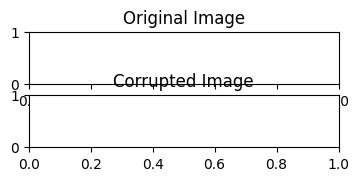

In [14]:
def corrupt(x,amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1,1,1,1)
    return (1 - amount) * x + amount * noise

fig, axs = plt.subplots(2,1,figsize=(4,1.5))
axs[0].set_title('Original Image')
# axs[0].imshow(torchvision.utils.make_grid(x)[0],cmap='gray')

amount = torch.linspace(0,1,x.shape[0])
nosised_x = corrupt(x,amount)

axs[1].set_title('Corrupted Image')
# axs[1].imshow(torchvision.utils.make_grid(nosised_x)[0],cmap='gray')

In [16]:
class BasicUNet(nn.Module):
    def __init__(self,in_channels=1,out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList([ 
            # [batch_size,1,28,28] -->[batch_size,32,28,28]
            nn.Conv2d(in_channels,32,kernel_size=5,padding=2),
            nn.Conv2d(32,64,kernel_size=5,padding=2),
            nn.Conv2d(64,64,kernel_size=5,padding=2)])
        self.up_layers = nn.ModuleList([
            nn.Conv2d(64,64,kernel_size=5,padding=2),
            nn.Conv2d(64,32,kernel_size=5,padding=2),
            nn.Conv2d(32,out_channels,kernel_size=5,padding=2)])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    def forward(self,x):
        h = []
        for i,l in enumerate(self.down_layers):
            x = l(x)
            x = self.act(x)
            if i < 2:
                h.append(x)
                x = self.downscale(x)
            # 第0层
            # 卷积、激活、下采样 [1,28,28]-->[32,28,28]-->[32,14,14]
            # h[0] [32,28,28]
            # 第1层
            # 卷积、激活、下采样 [32,14,14]-->[64,14,14]-->[64,7,7]
            # h[1] [64,14,14]
            # 第2层
            # 卷积、激活 [64,7,7]-->[64,7,7]
        for i,l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))
            # 第0层
            # 卷积、激活 [64,7,7]-->[64,7,7]
            # 第1层
            # 上采样、add、卷积、激活 [64,7,7]-->（[64,14,14]+[64,14,14]-->[64,14,14])-->[32,14,14]
            # 第2层
            # 上采样、add、卷积、激活 [32,14,14]-->([32,28,28]+[32,28,28]-->[32,28,28])-->[1,28,28]
        return x
net = BasicUNet()
x = torch.randn(8,1,28,28)
net(x).shape


torch.Size([8, 1, 28, 28])

In [17]:
sum([p.numel()for p in net.parameters()])

309057

Epoch 1, Loss: 0.02551
Epoch 2, Loss: 0.01956
Epoch 3, Loss: 0.01813


(0.0, 0.1)

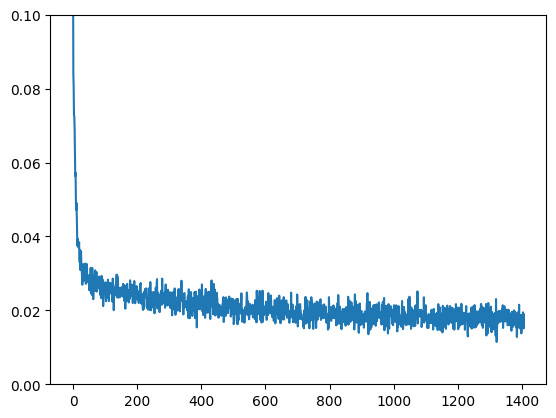

In [19]:
batch_size = 128
train_dataloader = train_dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

num_epochs = 3
net = BasicUNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(),lr=0.001)
losses = []
for epoch in range(num_epochs):
    for x,y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) #0~1
        noisy_x = corrupt(x,noise_amount)
        pred_y = net(noisy_x)  #[batch_size,1,28,28]
                               # x [batch_size,1,28,28]
        loss = loss_fn(pred_y,x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.05f}")
plt.plot(losses)
plt.ylim(0,0.1)

        

In [ ]:
x,y = next(iter(train_dataloader))
x = x[:8]

amount = torch.linspace(0,1,x.shape[0])
noised_x = corrupt(x,amount)

with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()
fig,axs = plt.subplots(3,1,figsize=(5,2.5))
axs[0].set_title('Original')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0,1),cmap='gray')

axs[1].set_title('Corrupted')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0,1),cmap='gray')

axs[2].set_title('Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0,1),cmap='gray');

In [ ]:
n_steps = 5
x = torch.rand(8,1,28,28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
    pred_output_history.append(pred.detach().cpu())
    mix_factor = 1/(n_steps-i)
    x = x*(1-mix_factor) + pred*mix_factor
    step_history.append(x.detach().cpu())
fig,axs = plt.subplots(n_steps,2,figsize=(9,4),sharex=True)
axs[0,0].set_title('Input')
axs[0,1].set_title('Output')
for i in range(n_steps):
    axs[i,0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0,1),cmap='gray')
    axs[i,1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0,1),cmap='gray')

In [ ]:
n_steps = 100
x = torch.rand(64,1,28,28).to(device)
for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor 
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(),nrow=8)[0].clip(0,1),cmap='gray')

In [27]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

NameError: name 'image_size' is not defined